## 1. Load asssociated libraries and data

In [20]:
# July, 2022, Evgenia Galytska (EG), IUP-UB.
#Application of PCMCI+ on Arctic-midlatitude research
# Import libraries
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import stats
import iris
import os
import xarray as xr
%matplotlib inline
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

import iris.analysis.cartography
from datetime import datetime as dt
from datetime import date, timedelta
import time
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import defaultdict #
import matplotlib.patheffects as path_effects
import pickle
import sys
import copy

############################Start of EG_functions##########################################
# add the path with additional functions to simplify the calculations
sys.path.append('/home/evgenia/tools/v3/Arctic-midlat/Python_scripts/functions')
#sys.path.append('/media/egalytska/Data_storage/tools/Arctic-midlat/Python_scripts/functions')

from functions_support import toYearFraction
from read_nc_files import load_1nc
from read_data_from_ESMValTool import read_Arctic_vars,read_Arctic_vars_noqbo_tas, read_model_data, read_model_data_noqbo_allt, read_siconca
from detrending import detrending
#from plot_1timeseries import plot_timeseries as pt
#from CMIP6_manipulations import colors_for_models 
#colors = colors_for_models ()
############################EG_functions##########################################

max_timelag = 5
masking_list = ["DJF"]#, "OND", "JFM"]

pc_alpha_list = [0.01]#, 0.01, 0.02, 0.05]
#pc_alpha_list = [None]

today = dt.now()
#create new firectory based on date of the run
#base_folder = "/media/egalytska/Data_storage/tools/Arctic-midlat/output/PCMCI_plus/scenario/"
base_folder = "/home/evgenia/tools/v3/Arctic-midlat/output/PCMCI_plus/scenario/"

os.makedirs (base_folder + "dicts_from_PCMCIplus/" + today.strftime("%d%m%Y")+ "/", exist_ok=True)
os.makedirs (base_folder + "txt/" + today.strftime("%d%m%Y")+ "/", exist_ok=True)

for masking in masking_list:
    for pc_element in pc_alpha_list:
        os.makedirs (base_folder + "CN/" + today.strftime('%d%m%Y')+ '/' + masking + '/' + str(pc_element), exist_ok=True)
        os.makedirs (base_folder + "Summary_plots/" + today.strftime('%d%m%Y')+ '/' + masking + '/' + str(pc_element), exist_ok=True)

        
        
#os.makedirs("/home/evgenia/tools/Arctic-midlat/output/PCMCI_plus/actors/" + today.strftime('%d%m%Y')+ "/OBS/", exist_ok=True)
#os.makedirs("/home/evgenia/tools/Arctic-midlat/output/PCMCI_plus/dictionaries/" + today.strftime('%d%m%Y')+ "/OBS/", exist_ok=True)

In [2]:
var_names = ['PV', 'TAS', 'vflux', 'Sib-SLP', 'Ural-SLP','Aleut-SLP', 'NAO', 'U', 'BK-SIC', 'Ok-SIC']

model_names = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'CanESM5', 'CMCC-CM2-SR5', 'CMCC-ESM2', 'EC-Earth3',
              'EC-Earth3-Veg',  'EC-Earth3-Veg-LR',  'GFDL-CM4', 'GFDL-ESM4',  'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 
              'MIROC6','MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0']

path       = '~/levante/work/bd0854/b380971/output/test_my_diagnostic/recipe_Arctic_telecon_develop_step_by_step_scenario_levante_20220616_143249/work/diagnostic_general/rename/'
path_cvdp  = '~/levante/work/bd0854/b380971/output/test_my_diagnostic/recipe_Arctic_telecon_cvdp_scenatio_20220615_131732/work/diagnostic_cvdp/cvdp/'


## 2. Load Arctic actors


In [3]:
dictionary = {}
for m in range (0, len (model_names)):
    dictionary.setdefault(model_names[m],{})
    print (model_names[m])
    #open general files
    data_models = load_1nc(path, model_names[m] + '.nc')
    #open cvdp files
    data_models_cvdp = xr.open_dataset (path_cvdp + model_names[m] + '.cvdp_data.2021-2099.nc', decode_times=False)
    year_2059 = [i for i,x in enumerate(data_models_cvdp.date.data) if x == 205901]
    year_2059 = year_2059[0]
    nao_m = data_models_cvdp.nao_timeseries_mon.data[year_2059:]
    enso_m = data_models_cvdp.nino34.data[year_2059:]
    pv_m, tas_m, tas_b_m, tas_s_m, sib_m, ural_m, aleut_m, zon_wind_m, vflux_m, sic_BK_m, sic_Ok_m, time_m = read_model_data_noqbo_allt (data_models)
    list_of_model_vals = [pv_m[year_2059:], tas_m[year_2059:], vflux_m[year_2059:], sib_m[year_2059:], ural_m[year_2059:], aleut_m[year_2059:],nao_m, zon_wind_m[year_2059:], sic_BK_m[year_2059:], sic_Ok_m[year_2059:]]
    for v in range (0, len (var_names)):
        dictionary[model_names[m]].setdefault(var_names[v], ())
        dictionary[model_names[m]][var_names[v]] = list_of_model_vals[v]

ACCESS-CM2
ACCESS-ESM1-5
BCC-CSM2-MR
CAMS-CSM1-0
CanESM5
CMCC-CM2-SR5
CMCC-ESM2
EC-Earth3
EC-Earth3-Veg
EC-Earth3-Veg-LR
GFDL-CM4
GFDL-ESM4
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0


In [4]:
time_new = pd.to_datetime(time_m[year_2059:], format='%m/%d/%Y')
month =  time_new.month
date_upd  = list ()
for i in range (0, len (time_new)):
    # add each converted value into list
    date_upd.append(toYearFraction(time_new[i]))
#convert list into array
year_fraction = np.asarray (date_upd)

## 3. Prepare data for Tigramite
#### Detrend each actor

In [5]:
for key in dictionary.keys ():
    for var in var_names:
#        print ( 'detrended', key, var)
        dictionary[key][var]          = detrending (dictionary[key][var])

#### Construct an array from detrended data for Causal Discovery

In [6]:
data= np.zeros(( len (dictionary.keys ()), len (time_new),  len (var_names)))
for i,val in enumerate (dictionary.keys ()):
    for j, val2 in enumerate (var_names):
        data[i, :, j] =  dictionary[val][val2]
M, T, N = data.shape
print("# Models   Data Length   No of Actors")
print( '   ',  M, '     ' ,T, '           ', N)  

# Models   Data Length   No of Actors
    19       492             10


DJF
Applying mask DJF
Calculating pc_alpha =  0.01


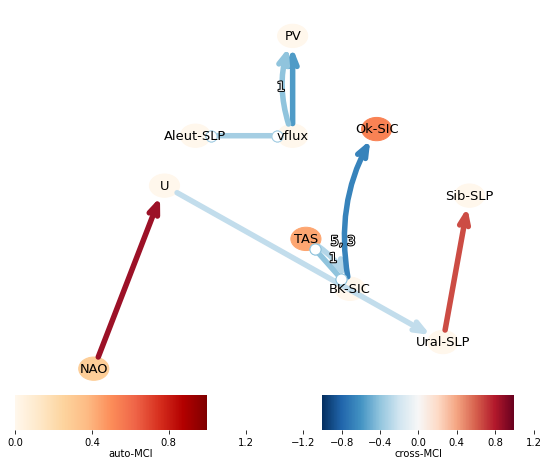

Calculating pc_alpha =  0.01


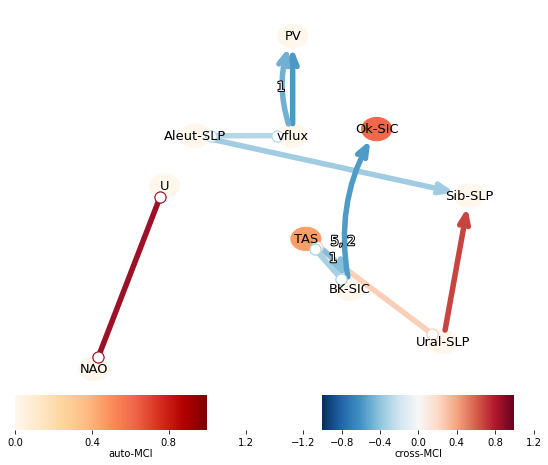

Calculating pc_alpha =  0.01


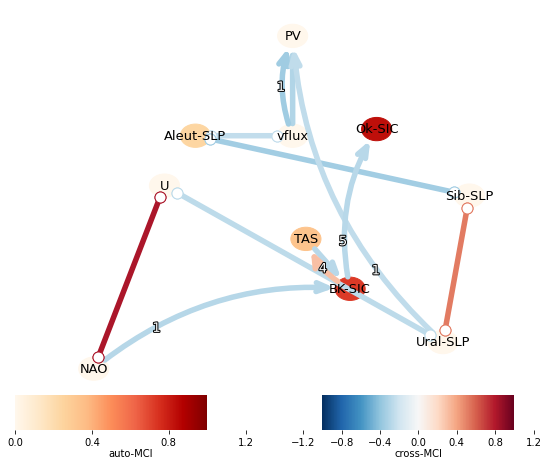

Calculating pc_alpha =  0.01


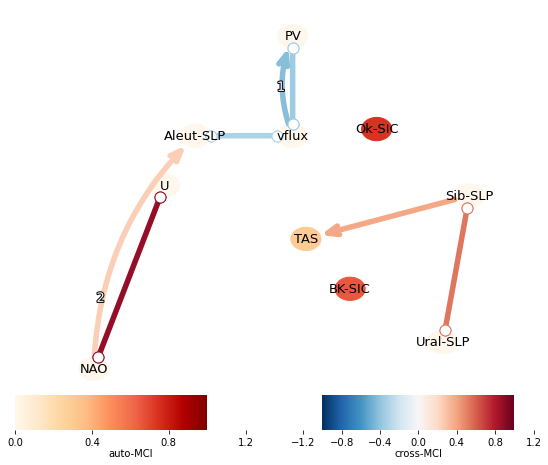

Calculating pc_alpha =  0.01


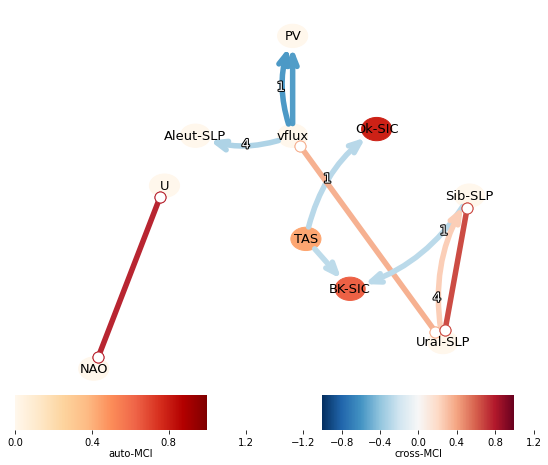

Calculating pc_alpha =  0.01


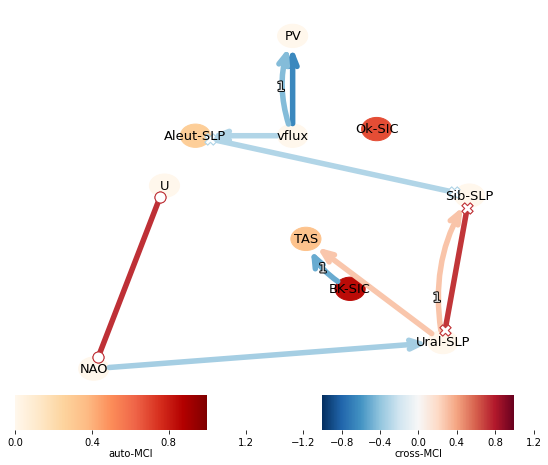

Calculating pc_alpha =  0.01


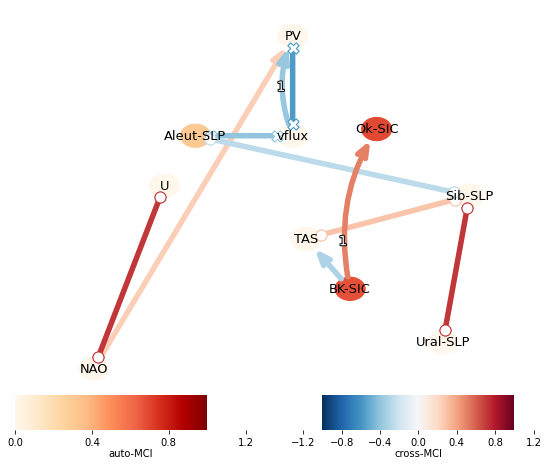

Calculating pc_alpha =  0.01


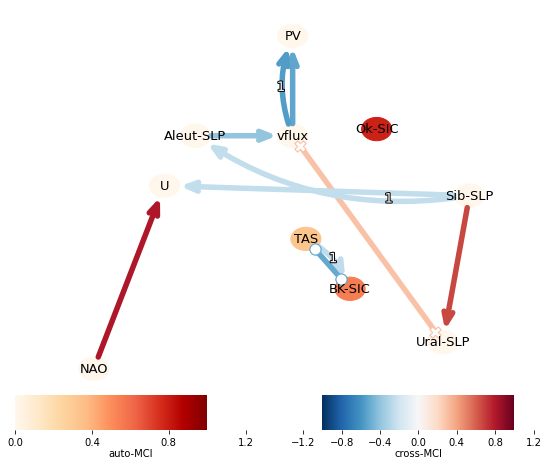

Calculating pc_alpha =  0.01


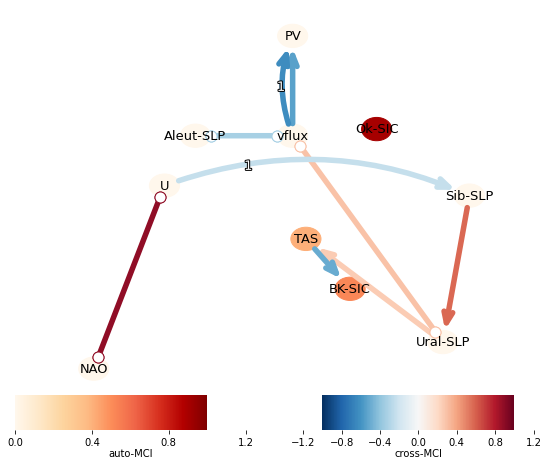

Calculating pc_alpha =  0.01


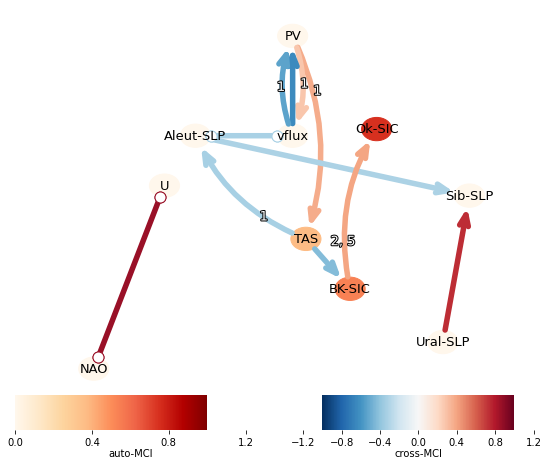

Calculating pc_alpha =  0.01


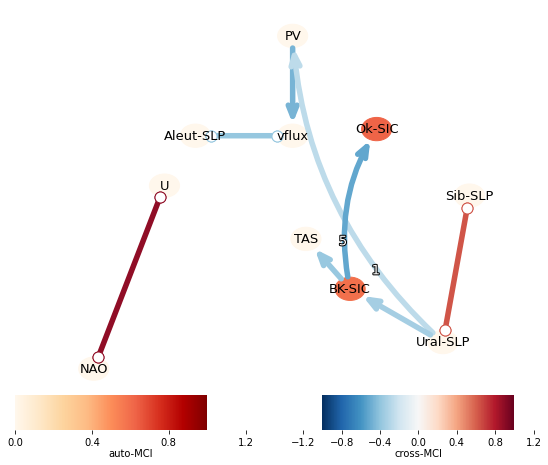

Calculating pc_alpha =  0.01


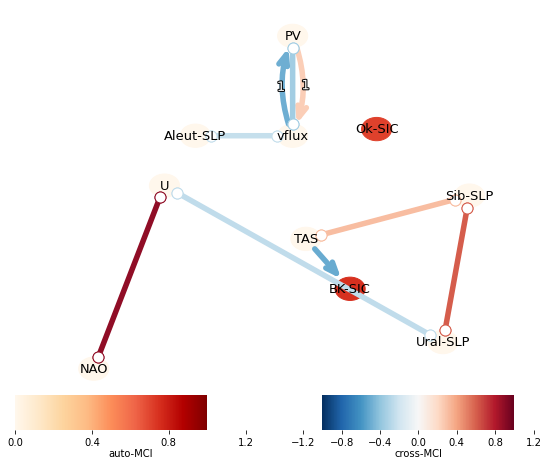

Calculating pc_alpha =  0.01


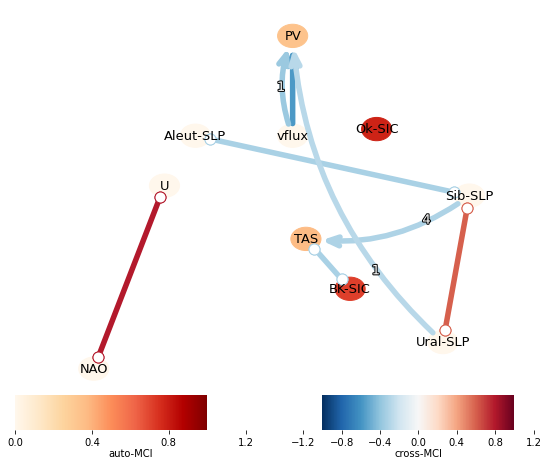

Calculating pc_alpha =  0.01


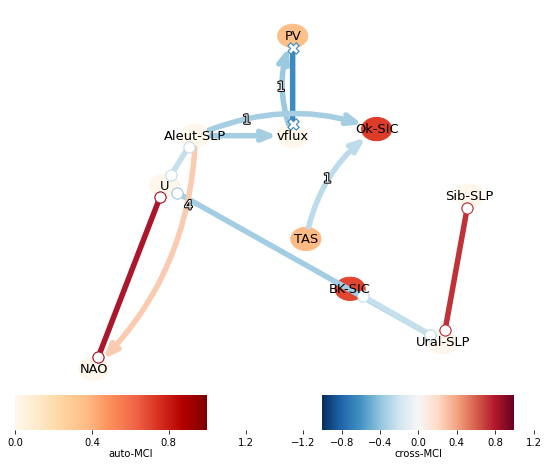

Calculating pc_alpha =  0.01


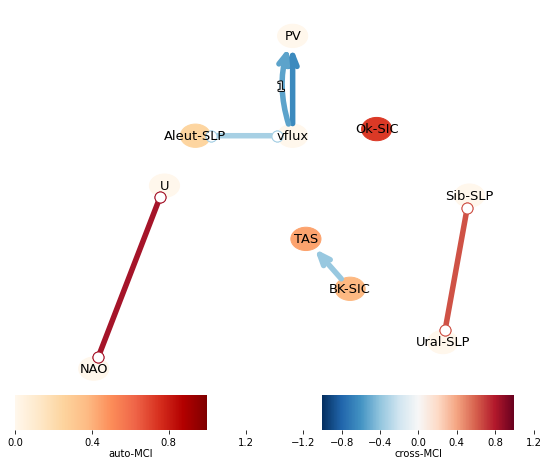

Calculating pc_alpha =  0.01


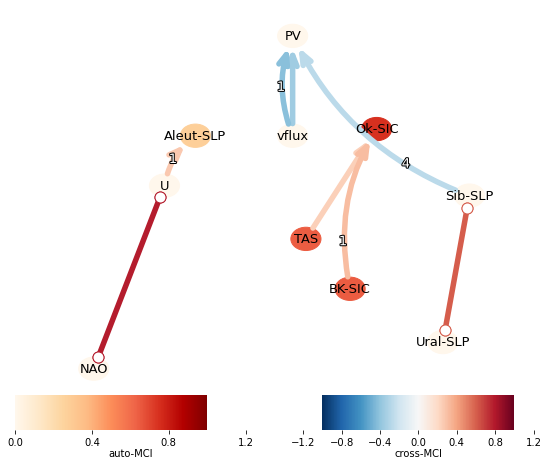

Calculating pc_alpha =  0.01


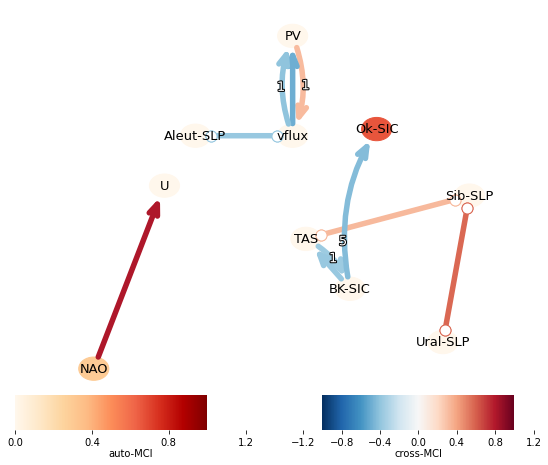

Calculating pc_alpha =  0.01


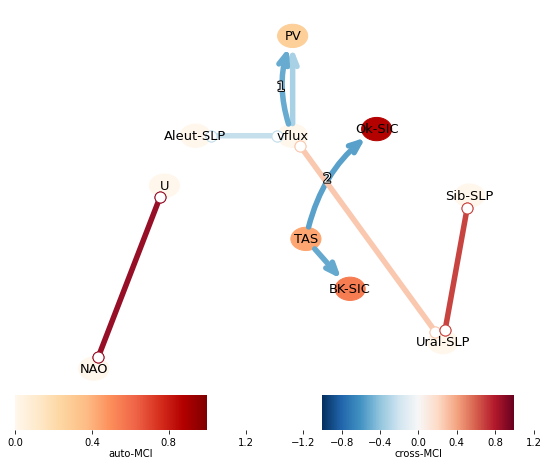

Calculating pc_alpha =  0.01


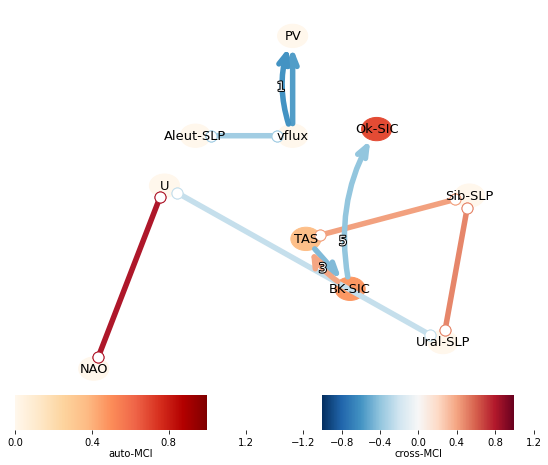

In [9]:
#Do you want to plot original causal graph from each data sourse?
plot_Causal_Graphs = True
#Do you want to save the dictionary with original data from the application of Causal Discovery?
save_orig_dict = True


dict_networks= {}
for masking in masking_list:
    print (masking)
    data_mask = np.zeros(data.shape)
    if masking == "OND":
        print ('Applying mask OND')
        data_masking= np.where(np.logical_and(month > 0, month < 10), 1,0) #!1 stands for data, which will be masked
    elif masking == "DJF":
        print ('Applying mask DJF')
        data_masking= np.where(np.logical_and(month > 2, month < 12), 1,0) #!1 stands for data, which will be masked
    elif masking == "JFM":
        print ('Applying mask JFM')
        data_masking= np.where(np.logical_and(month > 3, month < 13), 1,0) #!1 stands for data, which will be masked    
    for m in range (0, M):
        for n in range (0, N):
            data_mask[m, :, n] = data_masking
    for i,key in enumerate (dictionary.keys ()):
        for pc_element in pc_alpha_list:
            print ("Calculating pc_alpha = ", pc_element)

            dict_networks.setdefault(key,{})
#                dict_networks[key].setdefault ('season', {})
            dict_networks[key].setdefault (masking, {})
            dict_networks[key][masking].setdefault (pc_element, {})

            dataframe = pp.DataFrame(data[i, :, :], datatime = year_fraction, var_names = var_names, mask = data_mask[i, :, :])
            dataframe.mask = (dataframe.mask == True) # true vals will be masked
            parcorr = ParCorr(significance='analytic', mask_type = 'y')
            pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr, verbosity=0)
            results = pcmci.run_pcmciplus(tau_max=max_timelag, pc_alpha=pc_element)
            q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=max_timelag, fdr_method='fdr_bh')
            
            dict_networks[key][masking][pc_element].setdefault ('results', results)
            
            if plot_Causal_Graphs: 
            # Plotting Causal Graphs
                tp.plot_graph(
                                val_matrix=results['val_matrix'],
                               graph=results['graph'],
                               var_names=var_names,
                                figsize = (8,8),
                               #              var_names =  PV,  TAS, vflux, Sib, Ural, Aleut, NAO,    U, BK-SIC, Ok-SIC]####
           #
                                node_pos = {'x': np.array([ 6.0,  6.3,       6.0,      10,       9.4 ,        3.8 ,      1.5,    3.1,   7.3,   7.9 ]),
                                            'y': np.array([ 10.0, 3.9,      7.0,      5.2,       0.8,        7.0,       0.0,    5.5,   2.4,   7.2])},
                               node_size=0.7,       
                               link_colorbar_label='cross-MCI',
                               node_colorbar_label='auto-MCI', 
                               node_label_size = 13,
                               link_label_fontsize = 13, 
                               arrow_linewidth = 11, 
                       save_name = base_folder + "CN/" + today.strftime('%d%m%Y') + '/'+ masking + '/' + str(pc_element) + '/'+ key + '_PCMCIplus_pcalpha_'+str (pc_element)+"_" +str(len(var_names))+'actors_'+masking+'_scenario.png'),
                plt.show()

if save_orig_dict:
    #save complete dictionary 
    np.save(base_folder + "dicts_from_PCMCIplus/" + today.strftime('%d%m%Y') + '/'+ '1causal_links_historical_'+ masking + '_' + str(pc_element) + '_'+ str(len(var_names))+'actors_for_f1_scenario.npy', dict_networks)

# 5. Prepare data for Summary plot 
#### Can be used to reproduce Figs. S5-S7 from  Galytska et al., 2022

In [10]:
#Here sort oroginal data from the application of causal Discovery 
#into dictionary with correlation/autocorrelation values

#Decide whether you want to save the correlation/autocorrelation data into a new dictionary
save_corr_autocorr_data = True

# Do some fun!
dict_tigramite = {}

for key in dict_networks.keys ():
    dict_tigramite.setdefault(key,{})
    for masking in masking_list:
        dict_tigramite[key].setdefault (masking, {})
        for pc_element in pc_alpha_list:
            dict_tigramite[key][masking].setdefault (pc_element, {})
            dict_tigramite[key][masking][pc_element].setdefault('correlation', {})
            dict_tigramite[key][masking][pc_element].setdefault('autocorrelation', {})
            #for the autocorrelation
            test2_list = list ()
            #for the correlation
            vars1 = list ()
            lag_list = list ()
            vvv = list ()
            for i in range (0, len (var_names)):
                for j in range (0, len (var_names)): 
                    for k in range (0, (max_timelag +1)):
                        #If the link is detected: 
                        if dict_networks[key][masking][pc_element]['results']['graph'][i,j,k] != "":
                            # Replace unoriented and conflicted graphs with one symbol
                            if k==0: 
                                if dict_networks[key][masking][pc_element]['results']['graph'][i,j,k] == 'o-o' or \
                                dict_networks[key][masking][pc_element]['results']['graph'][i,j,k] == 'x-x' or \
                                dict_networks[key][masking][pc_element]['results']['graph'][i,j,k] == '-->' or \
                                dict_networks[key][masking][pc_element]['results']['graph'][i,j,k] == '<--':
                                    dict_networks[key][masking][pc_element]['results']['graph'][i,j,k] = '--'
                            
                            #First check the autocorrelation:
                            if var_names[i] == var_names[j]:
                                auto = 'autocorrelation'
                                test2_list.append ([var_names[i], k, dict_networks[key][masking][pc_element]['results']['val_matrix'][i,j,k]])
                                dict_tigramite[key][masking][pc_element][auto] = test2_list
                            #Now check instantaneous and causal links
                            else:
                                corr = 'correlation'
                                #vars1.append (var_names[i] +  symbol + var_names[j])
                               
                                
                                
                                vars1.append (var_names[i] + ' '+dict_networks[key][masking][pc_element]['results']['graph'][i,j,k]+ ' '+ var_names[j])

                                lag_list.append (k)
                                vvv.append (dict_networks[key][masking][pc_element]['results']['val_matrix'][i,j,k])
                                # Remove duplicates e.g.  PDO--NAO and NAO-- PDO
                                s = list ()
                                skipped = list ()
                                for ind, var in enumerate (vvv):
                                    if var not in s:
                                        s.append (var)
                                    else:
                                        skipped.append (ind)
                                for index in sorted(skipped, reverse=True):
        #                            print (index)
                                    del vvv[index], vars1[index], lag_list[index]

                                testing = list ()
                                for idn in range (0, len (vvv)):
                                    testing.append ([vars1[idn], lag_list[idn],vvv [idn] ])
                                dict_tigramite[key][masking][pc_element][corr] = testing

if save_corr_autocorr_data: 
    np.save(base_folder + '/dicts_from_PCMCIplus/' + today.strftime('%d%m%Y') + '/'+ '3sorted_corr_autocorr_historical_' + str(len(var_names))+'actors_scenario.npy', dict_tigramite)                           

In [11]:
all_possible_links = list ()
skipped = list ()
for key in dict_tigramite.keys ():
    for masking in masking_list:
        for pc_element in pc_alpha_list:
            for link in dict_tigramite[key][masking][pc_element]['correlation']:
                if link[0] not in all_possible_links:
                    all_possible_links.append (link[0])
                else:
                    skipped.append (link[0])
sorted_links = sorted (all_possible_links)

In [12]:
print ('Check what are the most frequent links (not sorted)')
(({i:skipped.count(i) for i in skipped}))

Check what are the most frequent links (not sorted)


{'BK-SIC --> Ok-SIC': 11,
 'PV -- vflux': 18,
 'TAS -- BK-SIC': 14,
 'TAS --> BK-SIC': 3,
 'vflux --> PV': 17,
 'vflux -- Aleut-SLP': 15,
 'Sib-SLP -- Ural-SLP': 18,
 'NAO -- U': 18,
 'Sib-SLP -- Aleut-SLP': 5,
 'Ural-SLP -- U': 4,
 'TAS -- Ural-SLP': 2,
 'Ural-SLP --> Sib-SLP': 1,
 'BK-SIC --> TAS': 2,
 'TAS -- Sib-SLP': 4,
 'vflux -- Ural-SLP': 3,
 'Ural-SLP --> PV': 2,
 'PV --> vflux': 2,
 'TAS --> Ok-SIC': 2,
 'Ural-SLP -- BK-SIC': 1}

In [13]:
interested_in_correlation = True
interested_in_autocorrelation = False

correlation_dict = {}
autocorrelation_dict = {}

if interested_in_correlation: 
    lll = list ()
    for key in dict_tigramite.keys ():
        correlation_dict.setdefault (key, {})
        for masking in masking_list:
            correlation_dict[key].setdefault(masking, {})
            for pc_element in pc_alpha_list:
                correlation_dict[key][masking].setdefault (pc_element, {})
                tr = defaultdict(list) # use defaultdictionary for a trick
                for a, b, c in dict_tigramite[key][masking][pc_element]['correlation']: 
                    tr[a].append ([b,c])
                lll.append (tr)
                correlation_dict[key][masking][pc_element].setdefault ('plotting', lll)

                
#Not yet programmed                
if interested_in_autocorrelation:
    
    lll_auto = list ()
    for key in dict_tigramite.keys ():
        autocorrelation_dict.setdefault (key, {})
        for masking in masking_list:
            autocorrelation_dict[key].setdefault(masking, {})
            for pc_element in pc_alpha_list:
                
                autocorrelation_dict[key][masking].setdefault (pc_element, {})
                tr_auto = defaultdict(list) # use defaultdictionary for a trick
                for a, b, c in dict_tigramite[key][masking][pc_element]['autocorrelation']: 
                    tr_auto[a].append ([b,c])
                lll_auto.append (tr_auto)
                autocorrelation_dict[key][masking][pc_element].setdefault ('plotting', lll)

In [14]:
modified_links = [ 'TAS -- BK-SIC', 'TAS -- Sib-SLP', 'TAS -- Ural-SLP', 'TAS --> Ok-SIC', 
                    'Sib-SLP -- Ural-SLP', 'Sib-SLP -- Aleut-SLP', 'Sib-SLP --> Aleut-SLP', 
                  'Ural-SLP --> Sib-SLP', 'Ural-SLP --> Ok-SIC', 'Ural-SLP --> PV','Ural-SLP -- NAO',
                  'BK-SIC --> Ok-SIC', 
                 'NAO -- BK-SIC', 'NAO --> BK-SIC', 'NAO -- U', 'NAO --> Aleut-SLP',
                  'PV -- NAO', 'PV -- vflux', 'PV --> vflux', 'PV --> Ok-SIC', 'PV -- TAS', 
                  'vflux --> PV', 'vflux -- Aleut-SLP', 'vflux -- Ok-SIC', 'vflux --> Ok-SIC', 'vflux -- Ural-SLP',
                  'vflux --> BK-SIC', 'vflux --> TAS', 
                  
                  'Aleut-SLP -- U', 'Aleut-SLP --> vflux', 'Aleut-SLP --> Sib-SLP', 'Aleut-SLP --> Ok-SIC', 
                  'Aleut-SLP -- Ok-SIC',
                  'U -- Ok-SIC', 'U --> vflux' , 
                  'Ural-SLP --> U', 'Ural-SLP -- BK-SIC', 'BK-SIC -- Ok-SIC', 
                  'Ok-SIC --> BK-SIC',
                  'BK-SIC --> TAS', 'TAS -- vflux', 'TAS -- Ok-SIC', 'TAS --> Aleut-SLP', 
                  'Aleut-SLP -- BK-SIC', 'Aleut-SLP --> NAO', 'NAO --> TAS', 
                 'PV -- Ural-SLP', 'Ok-SIC --> TAS', 'Sib-SLP -- Ok-SIC', 'Sib-SLP --> vflux'
    
]

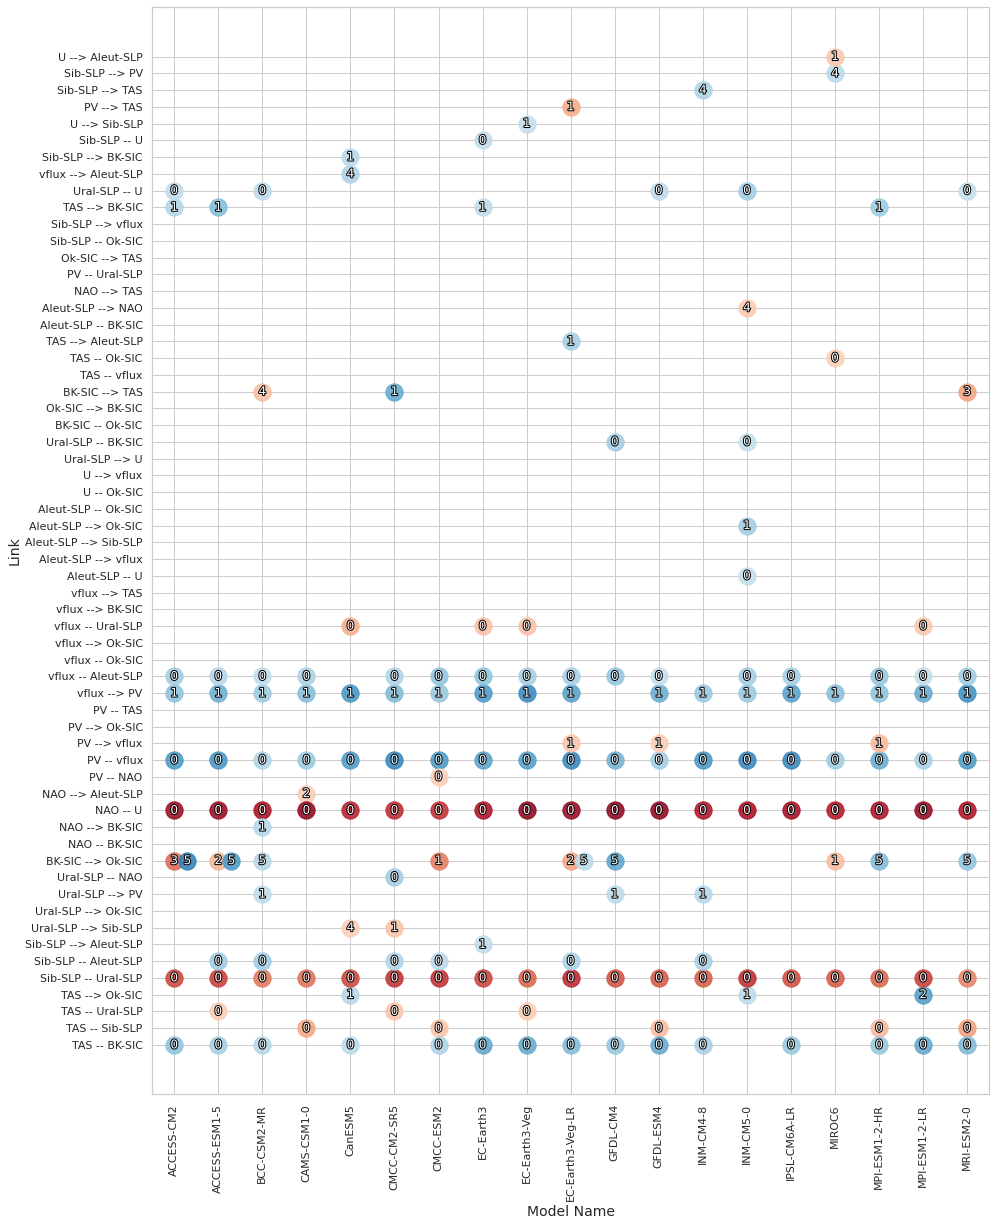

In [15]:
sns.set(style="whitegrid")
for masking in masking_list:
    for pc_element in pc_alpha_list:
        
        
        
        
        fig, ax = plt.subplots(figsize = (15, 20)) #
        mycmap = matplotlib.cm.get_cmap('RdBu_r')
        ax.set_xlim([-0.5, len(dict_tigramite.keys ())-0.5])
        ax.set_xticks(np.linspace(0, len(dict_tigramite.keys ())-1, len(dict_tigramite.keys ())))
        ax.set_xticklabels(dict_tigramite.keys (),fontsize=11, rotation=90)
        ax.set_xlabel('Model Name',fontsize=14) #, fontweight='bold')
        #ax.set_ylim([-1, len(sorted_links)+ 0.05])
        #ax.set_yticks(np.linspace(0, len(title)-1, len(title)))
        #ax.set_yticklabels(title, fontsize=9)
        ax.set_ylabel('Link',fontsize=14)#, fontweight='bold')

        plt.scatter (np.zeros(len (modified_links)),modified_links, color = 'white',s = 0)

        for n_model, key in enumerate (correlation_dict.keys ()): 
    

            tmp_var =  correlation_dict[key][masking][pc_element]['plotting'][n_model]
    
            for idx, variable in enumerate (list(tmp_var.keys())): 

    
#            for idx, variable in enumerate (list (lll[n_model].keys ())): 
                if len(list(tmp_var.values ())[idx]) > 1:
                    for idn,tt in enumerate (list(tmp_var.values ())[idx]):
                        # position (pos) of nodes is needed to define if you have several links between the same actors.
                        pos = n_model + np.linspace (0, 0.3, len (list(tmp_var.values ())[idx])) 
                        pfc = plt.scatter(pos[idn], list (tmp_var.keys ())[idx], c=list(tmp_var.values ())[idx][idn][1], vmin=-1.0, vmax=1.0, marker="o",  alpha=0.9,  s = 300, cmap=mycmap)
                        text = plt.text(pos[idn], list (tmp_var.keys ())[idx], s=(list(tmp_var.values ())[idx][idn][0]), color='white',  verticalalignment='center', horizontalalignment='center') 
                        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), 
                                               path_effects.Normal()])  


                else: 
                    pfc = plt.scatter(key, variable, c=(list(tmp_var.values ())[idx][0][1]), vmin=-1.0, vmax=1.0, marker="o",  alpha=0.9, s = 300, cmap=mycmap)
                    text = plt.text(key, variable, s=(list(tmp_var.values ())[idx][0][0]), color='white',  verticalalignment='center', horizontalalignment='center') 
                    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                               path_effects.Normal()])    
        plt.savefig (base_folder + 'Summary_plots/' + today.strftime('%d%m%Y') + '/'+ masking + '/' + str (pc_element) + '/SUMMARY_presentation_2059-2099_'+masking + '_' + str (pc_element) + '.png', dpi= 120, bbox_inches = "tight")
                     

In [15]:
# The last routine is to count how many models give identical to OBS link

In [22]:
#dict_networks_orig = copy.deepcopy(dict_networks)
fin_dict = {}
#symbols_list = ['o-o', 'x-x' , '-->', '<--']
symbols_list = ['--', '-->']

for masking in masking_list:
    fin_dict.setdefault(masking, {})
    for pc_element in pc_alpha_list:
        fin_dict[masking].setdefault(pc_element, {})

        fin_result_list = list()
        for idx, symbol in enumerate (symbols_list):
            
            link_matrix_list = list ()
            
            for key in dict_networks.keys ():
                t = np.zeros ((10,10, 6))
                for i in range (0, N):
                    for j in range (0, N): 
                        for k in range (0, (max_timelag +1)):
                            if dict_networks[key][masking][pc_element]['results']['graph'] [i,j,k] == symbol: 
                                t[i,j,k] = 1
                                dict_networks[key][masking][pc_element]['results'].setdefault ('val'+str(idx+1), t)

                            else:
                                t [i,j,k] = 0 
                                dict_networks[key][masking][pc_element]['results'].setdefault ('val'+str(idx+1), t)

                
                link_matrix=dict_networks[key][masking][pc_element]['results']['val'+str(idx+1)].astype(int)
                link_matrix_list.append (link_matrix)
                    
            with open('/home/evgenia/tools/Arctic-midlat/output/PCMCI_plus/dicts_from_PCMCIplus/14072022/2OBS_results_links_1979-2019_'+masking +'_'+ str(pc_element)+ '_10actors.pickle', 'rb') as handle:
                link_matrix_obs = pickle.load(handle)
                for i in range (0, N):
                    for j in range (0, N): 
                        for k in range (0, (max_timelag +1)):
                            if link_matrix_obs[i,j,k] == "":
                                link_matrix_obs[i,j,k] = 0
                            else:
                                link_matrix_obs[i,j,k] = 1
#            link_matrix_obs = dict_networks["OBS"][masking][pc_element]['results']['val'+str(idx+1)]
                    
    
            my_sum = np.sum(link_matrix_list, axis=0)    
            other_result = my_sum * link_matrix_obs.astype(int) # multiply by obs to show only those links, that are present at observations
            fin_result_list.append (other_result)  
        fin_dict[masking][pc_element].setdefault('count_symbol',np.sum (fin_result_list, axis = 0))
            

In [23]:
base_folder

'/home/evgenia/tools/v3/Arctic-midlat/output/PCMCI_plus/scenario/'

In [25]:
path_save_txt=base_folder + 'txt/'+ today.strftime('%d%m%Y') + '/'

# Save data in the file
for masking in masking_list:
    print ('--------------', masking, '--------------')
    for pc_element in pc_alpha_list:
        print ('-------------', pc_element, '-------------')
        filewr=path_save_txt+'obs_vs_models_'+str(masking) + str (pc_element)+ '.txt'
        fhand=open(filewr,'w+')

        for i in range (0, N):
            for j in range (0, N): 
                for k in range (0, (max_timelag +1)):

                    if fin_dict[masking][pc_element]['count_symbol'][i,j,k] > 0 and i!=j: 
        #                if var_names[i] == 'NAO' and var_names[j] == 'v-flux':
                        if var_names[i] !=var_names[j]:
                            print (var_names[i],   var_names[j], 'lag:', k,  '#models', fin_dict[masking][pc_element]['count_symbol'][i,j,k])
                            fhand.write('{0:>10}{1:>10}{2:>3d}{3:4d}\n'.format (str (var_names[i]), str (var_names[j]), k, fin_dict[masking][pc_element]['count_symbol'][i,j,k]))                
        fhand.close() 

-------------- DJF --------------
------------- 0.01 -------------
PV vflux lag: 0 #models 19
TAS Sib-SLP lag: 0 #models 5
vflux PV lag: 0 #models 19
vflux PV lag: 1 #models 18
vflux Aleut-SLP lag: 0 #models 16
Sib-SLP TAS lag: 0 #models 5
Sib-SLP Ural-SLP lag: 0 #models 19
Ural-SLP PV lag: 1 #models 3
Ural-SLP Sib-SLP lag: 0 #models 19
Aleut-SLP vflux lag: 0 #models 16
Aleut-SLP Ok-SIC lag: 1 #models 1
NAO U lag: 0 #models 19
NAO BK-SIC lag: 1 #models 1
U NAO lag: 0 #models 19
